# **Source**:

https://www.kaggle.com/datasets/manjitbaishya001/airbnb-new-york-jan-2024?select=detailed_reviews.csv, sourced from Airbnb Description: Airbnb
data from New York focussing on listings, locations, and user reviews of
locations

# **What is the Dataset about?**:

This dataset contains listings of Airbnbs in New York, listing features such as what type of housing it is (Rental Unit, Loft, etc.) and the price of the Airbnb. Note that there are several rows with missing values in the price column, which are dealt with during Data Preprocessing. Other features include the name of the host, neighbourhood group, neighbourhood, latitude, longitude, minimum nights to stay, number of reviews about the establishment, the date of the last review, and reviews per month. These features can be used to estimate what an accurate valuation of the Airbnb might be.

There is also a dataset with detailed reviews for each Airbnb, which can be used to evaluate the quality of the listing based on user experiences.


# **Data Preprocessing**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# importing dataset and organizing
listings_df = pd.read_csv("./dataset/listings.csv")

# dropping all listings with a NA price as the percentage of NAs is more than 5%
# and imputation on a feature as complex as a listing price seems unnecessary
# given the quanitity of listings that do have an associated price
listings_df = listings_df.dropna(subset=['price'])

# all values are in the correct format
print("Data Types: ", list(listings_df.dtypes))


print(3*"\n", "Dataframe:")

listings_df.head()

listings_df.drop(["license", "last_review", "id", "host_name", "name"], axis=1, inplace=True)
print(listings_df.size, (listings_df.dropna()).size)
listings_df = listings_df.dropna()

encoded_data = listings_df.copy(deep=True) 
list_cols_to_encode = ["neighbourhood_group", "neighbourhood", "room_type"] 
for i in list_cols_to_encode: 
    encoded_data[i] = encoded_data[i].replace(encoded_data[i].unique(), [j for j in range(len(encoded_data[i].unique()))]) 
    
encoded_data.head()

Data Types:  [dtype('int64'), dtype('O'), dtype('int64'), dtype('O'), dtype('O'), dtype('O'), dtype('float64'), dtype('float64'), dtype('O'), dtype('float64'), dtype('int64'), dtype('int64'), dtype('O'), dtype('float64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('O')]



 Dataframe:
378183 269854


C:\Users\elena\AppData\Local\Temp\ipykernel_21108\1716153161.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  encoded_data[i] = encoded_data[i].replace(encoded_data[i].unique(), [j for j in range(len(encoded_data[i].unique()))])


,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
8,7130382,0,0,40.683710,-73.964610,0,55.0,30,3,0.03,1,0,0
28,51501835,1,1,40.766610,-73.988100,1,144.0,30,9,0.24,139,364,2
38,528871354,1,2,40.750764,-73.994605,1,187.0,2,6,1.67,1,343,6
40,19902271,1,3,40.835600,-73.942500,0,120.0,30,156,1.38,2,363,12
45,61391963,1,4,40.751120,-73.978600,1,85.0,30,11,0.24,133,335,3


# **Data exploration and summary statistics**

## **Statistical Method #1**

**Null Hypothesis ($H_{0}$) :** The neighborhood group of the Airbnb does not have a statistically significant impact on the availability for the Airbnb.

**Alternative Hypothesis ($H_{a}$) :** The neighborhood group of the Airbnb has a statistically significant impact on the availability for the Airbnb.

**Alpha-Value ($a$) :** 0.05

**Confidence level:** 95%

Kruskal-Wallis Test Statistic: 112.97208443868276
P-Value: 1.6903863188481304e-23
neighbourhood_group
Bronx            237.586934
Staten Island    232.350515
Queens           212.205796
Manhattan        203.919134
Brooklyn         200.240316
Name: availability_365, dtype: float64


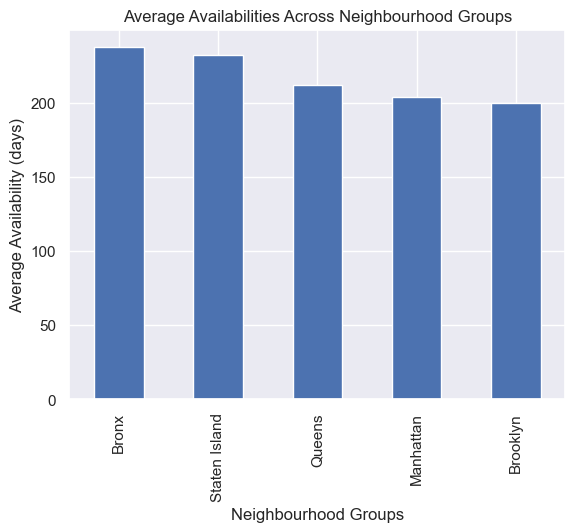

In [ ]:
import numpy as np
from scipy.stats import kruskal

# Group by neighborhood group and calculate mean availability
df_groups = listings_df.groupby('neighbourhood_group')['availability_365'].mean().sort_values(ascending=False)

# Convert mean availability to a list
mean_availability = df_groups.tolist()

# Perform Kruskal-Wallis test to compare mean availability across neighborhood groups
statistic, p = kruskal(*[listings_df[listings_df['neighbourhood_group'] == group]['availability_365'] for group in df_groups.index])

print("Kruskal-Wallis Test Statistic:", statistic)
print("P-Value:", p)
print(df_groups)

# Plotting the graph
df_groups.plot.bar()
plt.ylabel('Average Availability (days)')
plt.xlabel('Neighbourhood Groups')
plt.title('Average Availabilities Across Neighbourhood Groups')
plt.show()

Since the p-value is lower than the confidence interval, we can reject the null hypothesis. This means that the location has a statistically significant impact on the availability for the Airbnb. The most available Airbnbs are located in Staten Island, and the least available Airbnbs are in Brooklyn.

This is important for the machine learning model because the model should take into account that there are disproportionate availabilities based on the location of the Airbnb. The pricing model will weight this as well.

## **Statistical Method #2**

**Null Hypothesis ($H_{0}$) :** The neighbourhoods in Manhattan do not have a statistically significant impact on the mean prices for Entire home/apt units.

**Alternative Hypothesis ($H_{a}$) :** The neighbourhoods in Manhattan have a statistically significant impact on the mean prices for Entire home/apt units.

**Alpha-Value ($a$) :** 0.05

**Confidence level:** 95%

P-Value: 2.596647049069326e-29


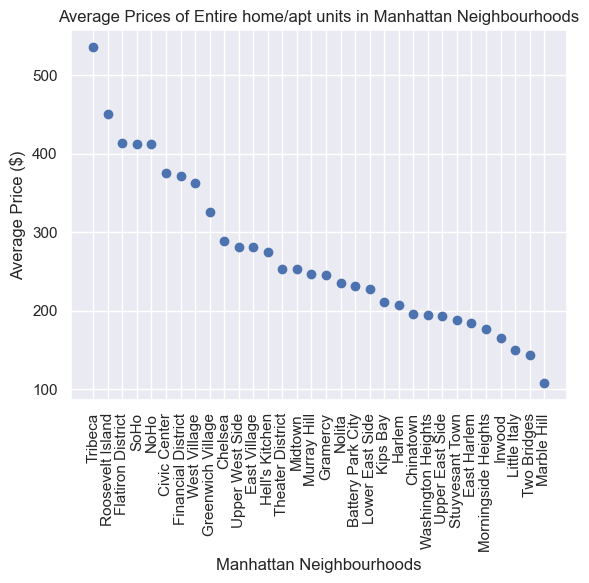

In [ ]:
from scipy.stats import f_oneway

# Filter the dataset to include only listings in Manhattan with 'Entire home/apt' room type
df_manhattan = listings_df[(listings_df['neighbourhood_group'] == 'Manhattan') & (listings_df['room_type'] == 'Entire home/apt')]

# Group by neighborhood and calculate mean prices for 'Entire home/apt' units
df_groups = df_manhattan.groupby('neighbourhood')['price'].mean().sort_values(ascending=False)
mean_prices = list(df_groups)

# Perform one-way ANOVA test to test for statistically significant differences between the mean prices of neighborhoods
statistic, p = f_oneway(*[df_manhattan[df_manhattan['neighbourhood'] == neighborhood]['price'] for neighborhood in df_groups.index])

print("P-Value:", p)

# Plot the scatter plot
plt.scatter(df_groups.index, mean_prices)
plt.xticks(rotation=90)
plt.ylabel('Average Price ($)')
plt.xlabel('Manhattan Neighbourhoods')
plt.title('Average Prices of Entire home/apt units in Manhattan Neighbourhoods')
plt.show()

As the p-value (7.9997e-22) is less than the alpha value of 0.05, we can reject the null hypothesis and conclude that there is a significant difference in the prices of Entire home/apt units between Manhattan neighbourhoods. Tribeca is the most expensive location in Manhattan based on the data provided/present for entire home/apts, with an average price of approximately $595. These findings allude to the fact that New York's neighbourhood groups have a varying price range of entire home/apt units throught their neighbourhoods.

## **Statistical Method #3**

**Null Hypothesis ($H_{0}$) :** The number of reviews of an Airbnb does not have a statistically significant impact on the price of the Airbnb.

**Alternative Hypothesis ($H_{a}$) :** The number of reviews of an Airbnb has a statistically significant impact on the price of the Airbnb.

**Alpha-Value ($a$) :** 0.05

**Confidence level:** 95%

T-statistic: 4.804976232204855
P-value: 1.5585135406409729e-06


C:\Users\elena\AppData\Local\Temp\ipykernel_21108\3507438044.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=new_df, x="price", y="number_of_reviews", linewidth = 0.5, palette="mako_r", alpha=1)


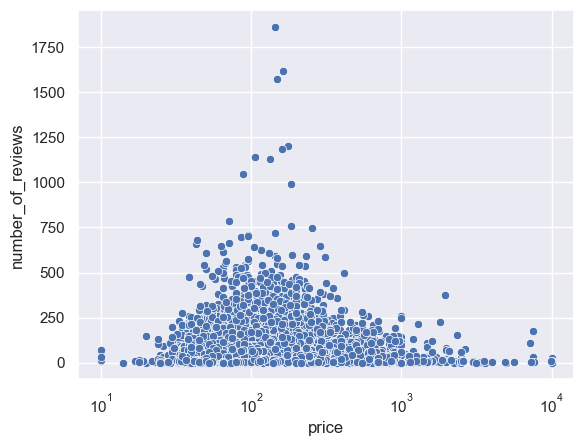

In [ ]:
# using a threshold that listings with a number of reviews of lesser than 50 is
# regarded as 'Low' number of reviews and those with higher than 50 is regarded
# as 'High' number of reviews.

# taking out outliers (only 7 listings have prices higher than 19000 and may
# ruin integrity of our dataset)
new_df = listings_df[listings_df["price"] < 19000.0]

low_df = new_df[new_df['number_of_reviews'] < 50]
high_df = new_df[new_df['number_of_reviews'] >= 50]

low_prices = low_df['price']
high_prices = high_df['price']

t_statistic, p_value = stats.ttest_ind(low_prices, high_prices)

print("T-statistic:", t_statistic)
print("P-value:", p_value)

# plotting the graph
sns.scatterplot(data=new_df, x="price", y="number_of_reviews", linewidth = 0.5, palette="mako_r", alpha=1)
plt.xscale('log')


The p-value of 1.444e-17 is extremely small, indicating strong evidence against the null hypothesis.

Given the very small p-value, much smaller than the typical significance level of 0.05, we reject the null hypothesis. Therefore, we conclude that there is a statistically significant difference in mean prices between the low and high review groups.

If there's a significant difference in mean prices between listings with low and high review counts, this finding could have implications for pricing strategy. For example, it might suggest that listings with higher review counts can command higher prices, potentially reflecting greater perceived value among customers.

# **Initial Conclusions through Exploratory Analysis**

Through our exploratory data analysis and basic data cleaning (the data was pretty clean to begin with) we hope to build a machine learning model to predict the price of Airbnb listings based on features such as location, property type, number of bedrooms, amenities, and historical booking data. This could help hosts optimize their pricing strategy and maximize their revenue.

Through our aforementioned Hypothesis Testing, we have found correlatory evidence in features provided in the dataset and being able to predict the value of a listing. This provides a positive outlook onto being able to create a Machine Learning pricing model in the future.

### imports


In [ ]:
import os
import tarfile
import requests
import torch
from torch.utils.data import Dataset
import pandas as pd
import cv2
import os
import torch.nn as nn
import torch.nn.functional as F
import math
import tqdm
import copy
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.preprocessing import StandardScaler


### model definition


In [ ]:
#

class Net(nn.Module):
  def __init__(self, n_classes):
    super().__init__()

    self.conv = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=4, stride=1, padding=1)

    self.fc1 = nn.Linear(8 * 6 * 7, n_classes)
    self.fc2 = nn.Linear(n_classes, 1)

  def forward(self, x):
    x = x.unsqueeze(1)
    x = self.conv(x)
    x = F.relu(x)
    x = x.view(x.size(0), -1)

    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    return x


model = nn.Sequential(
    nn.Linear(12, 48),
    nn.ReLU(),
    nn.Linear(48, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
).float()

In [ ]:
n_epochs = 50
batch_size = 10

### train model using train and validation datasets

In [ ]:
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# # train-test split of the dataset
# X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.7, shuffle=True)
# X_train = torch.tensor(X_train, dtype=torch.float32)
# y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
# X_test = torch.tensor(X_test, dtype=torch.float32)
# y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

train_size = int(0.8 * len(encoded_data))
test_size = int(0.1 * len(encoded_data) + 1)
val_size = int(0.1 * len(encoded_data) + 1)


train_set, test_set, val_set = torch.utils.data.random_split(encoded_data, [train_size, test_size, val_size])

x_train = encoded_data.iloc[list(train_set.indices)]
y_train = x_train['price'].values.reshape(-1, 1)
x_train = x_train = x_train.drop('price', axis=1).to_numpy().astype(float)

x_test = encoded_data.iloc[list(test_set.indices)]
y_test = x_test['price'].values.reshape(-1, 1)
x_test = x_test.drop('price', axis=1).to_numpy().astype(float)

x_val = encoded_data.iloc[list(val_set.indices)]
y_val = x_val['price'].values.reshape(-1, 1)
x_val = x_val.drop('price', axis=1).to_numpy().astype(float)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

scaler2 = StandardScaler()
y_train = scaler2.fit_transform(y_train)
y_test = scaler2.transform(y_test)
y_val = scaler2.transform(y_val)

y_train = [item[0] for item in y_train]
y_val = [item[0] for item in y_val]
y_test = [item[0] for item in y_test]

x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
x_val = torch.tensor(x_val, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

# Hold the best model
best_mse = np.inf   # init to infinity
best_model = None
mse_store = []
loss_store = []
eval_epochs = 0
batch_start = torch.arange(0, len(x_train), batch_size)

# training loop
for epoch in range(n_epochs):

    model.train()

    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")

        for start in bar:

            # take a batch
            X_batch = x_train[start:start+batch_size].float()
            y_batch = y_train[start:start+batch_size].float()


            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)

            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # print progress
            bar.set_postfix(mse=float(loss))

    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(x_val)

    eval_epochs += 1

    mse = loss_fn(y_pred, y_val)

    mse = float(mse)
    mse_store.append(mse)
    loss_store.append(loss.item())

    print(f"Epoch: {epoch}, Train Loss: {loss.item()} Eval Loss: {mse}")

    if mse < best_mse:
        best_mse = mse
        best_model = copy.deepcopy(model.state_dict())

# Save your model's weights
model.load_state_dict(best_model)
torch.save(model.state_dict(), "model.pth")

c:\Users\elena\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\elena\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\elena\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2076])) that is different to the input size (torch.Size([2076, 1])). This will likely lead to inc

Epoch: 0, Train Loss: 0.007757982239127159 Eval Loss: 0.08485160022974014
Epoch: 1, Train Loss: 0.007699362933635712 Eval Loss: 0.08484134078025818
Epoch: 2, Train Loss: 0.007847118191421032 Eval Loss: 0.0849076360464096
Epoch: 3, Train Loss: 0.00790685135871172 Eval Loss: 0.08489047735929489
Epoch: 4, Train Loss: 0.007815220393240452 Eval Loss: 0.08487784117460251
Epoch: 5, Train Loss: 0.007744340226054192 Eval Loss: 0.08488019555807114
Epoch: 6, Train Loss: 0.00799640454351902 Eval Loss: 0.0849616676568985
Epoch: 7, Train Loss: 0.007881959900259972 Eval Loss: 0.08490152657032013
Epoch: 8, Train Loss: 0.007901742123067379 Eval Loss: 0.08493546396493912
Epoch: 9, Train Loss: 0.007714726962149143 Eval Loss: 0.08485256880521774
Epoch: 10, Train Loss: 0.00796910934150219 Eval Loss: 0.08500952273607254
Epoch: 11, Train Loss: 0.008027547039091587 Eval Loss: 0.08499322086572647
Epoch: 12, Train Loss: 0.007677129469811916 Eval Loss: 0.08488065749406815
Epoch: 13, Train Loss: 0.008098005317151

### plot training and eval loss values




In [ ]:
# restore model and return best accuracy
model.load_state_dict(best_model)

<All keys matched successfully>

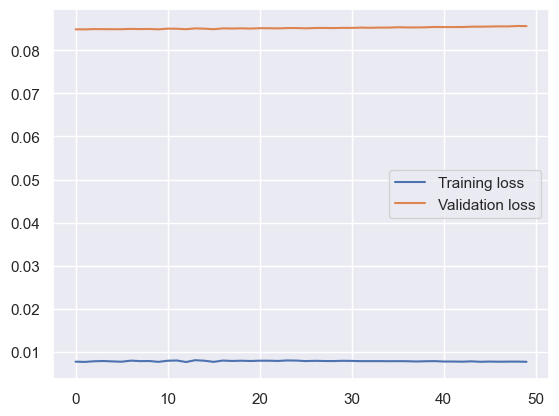

In [ ]:
# Plot the training and validation loss
plt.plot(range(eval_epochs), loss_store, label='Training loss')
plt.plot(range(eval_epochs), mse_store, label='Validation loss')
plt.legend()
plt.show()

# testing model on test set


In [ ]:
# Load from your saved model using torch.load
# model_state_dict = torch.load("./model.pth")
# model.load_state_dict(model_state_dict)

# set model to inference mode
model.eval()
batch_size = 1
preds = []

test_loader = DataLoader(x_test, batch_size=batch_size, shuffle=False)


with torch.no_grad():

  for x in tqdm.tqdm(test_loader):

    y_pred = model(x)

    preds.append(y_pred)


# Get the true labels for the validation dataset
# true_y = torch.tensor(y_test)
preds = torch.tensor(preds)


mse_loss = nn.MSELoss()
mse = mse_loss(preds, y_test)
print(f"mse: {mse}")

100%|██████████| 2076/2076 [00:00<00:00, 9211.84it/s]

mse: 0.061381638050079346
